# EDA + Retrieval

In [1]:
## imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np


ROOT = Path.cwd().resolve()
while not (ROOT / "artifacts").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

DATA = ROOT / "data"
ART = ROOT / "artifacts"

print("ROOT:", ROOT)
print("DATA:", DATA, "exists:", DATA.exists())
print("ART :", ART,  "exists:", ART.exists())


ROOT: C:\Users\GLORIA MARENA\projects\context-engine-crewai
DATA: C:\Users\GLORIA MARENA\projects\context-engine-crewai\data exists: True
ART : C:\Users\GLORIA MARENA\projects\context-engine-crewai\artifacts exists: True


In [3]:
print((ART / "items.parquet").exists(), ART / "items.parquet")
print((ART / "events.parquet").exists(), ART / "events.parquet")
print((ART / "retrieval_artifacts.pkl").exists(), ART / "retrieval_artifacts.pkl")


True C:\Users\GLORIA MARENA\projects\context-engine-crewai\artifacts\items.parquet
True C:\Users\GLORIA MARENA\projects\context-engine-crewai\artifacts\events.parquet
True C:\Users\GLORIA MARENA\projects\context-engine-crewai\artifacts\retrieval_artifacts.pkl


In [ ]:
# dataset

In [4]:
import pandas as pd

items_path = ART / "items.parquet"
events_path = ART / "events.parquet"
item360_path = ART / "item_360.parquet"

items = pd.read_parquet(items_path)
events = pd.read_parquet(events_path)

print("items shape:", items.shape)
print("events shape:", events.shape)

if item360_path.exists():
    item360 = pd.read_parquet(item360_path)
    print("item360 shape:", item360.shape)
else:
    item360 = None


items shape: (100000, 26)
events shape: (10000, 4)
item360 shape: (100000, 15)


In [5]:
display(items.head(3))
display(events.head(3))

print("items columns:", list(items.columns))
print("events columns:", list(events.columns))


,item_id,title,date_created,base_price,price,category_id,variations,pictures,seller_id,seller_country,...,shipping_is_free,status,sub_status,warranty,is_new,initial_quantity,sold_quantity,available_quantity,tags_json,attributes_json
0,MLA578569012,Escritorio Secretter Espectacular,2015-09-08T21:17:57.000Z,6700.0,6700.0,MLA1902,[],"[{'size': '500x375', 'secure_url': 'https://a2...",99151748,Argentina,...,False,active,None,None,0,1.0,0.0,1.0,"[""dragged_bids_and_visits""]",{}
1,MLA576883746,Stassen Espatulas Milenio Numero 3 Codigo 590-3,2015-08-29T12:55:03.000Z,119.0,119.0,MLA3530,[],"[{'size': '500x375', 'secure_url': 'https://a2...",65545512,Argentina,...,False,active,None,Sí,1,19.0,0.0,19.0,"[""dragged_bids_and_visits""]",{}
2,MLA581002506,Charm Britania Plata 925 Ovalado!!! Armá La Tu...,2015-09-23T12:41:07.000Z,450.0,450.0,MLA6440,[],"[{'size': '312x308', 'secure_url': 'https://a2...",101563090,Argentina,...,False,active,None,Sí,1,2.0,0.0,2.0,"[""dragged_bids_and_visits""]",{}


,event_id,query,event_ts,clicked_item_id
0,E000000,audifonos bluetooth con cancelación de ruido,2026-01-05 13:30:00,MLA580332585
1,E000001,Busco una laptop para edición de video que sea...,2026-01-08 14:42:00,MLA581808423
2,E000002,tv 4k smart economico,2026-01-02 08:26:00,MLA582568132


items columns: ['item_id', 'title', 'date_created', 'base_price', 'price', 'category_id', 'variations', 'pictures', 'seller_id', 'seller_country', 'seller_province', 'seller_city', 'seller_loyalty', 'buying_mode', 'shipping_mode', 'shipping_admits_pickup', 'shipping_is_free', 'status', 'sub_status', 'warranty', 'is_new', 'initial_quantity', 'sold_quantity', 'available_quantity', 'tags_json', 'attributes_json']
events columns: ['event_id', 'query', 'event_ts', 'clicked_item_id']


In [ ]:
# EDA (EXPLORACIÓN)

In [7]:
def eda_basic(df, name="df"):
    if df is None:
        print(f"=== {name} is None, skipping ===")
        return

    print(f"\n{'='*10} {name} {'='*10}")
    print(f"Shape: {df.shape}")
    
    # 1. Tipos de datos
    print("\nDtypes:")
    print(df.dtypes)
    
    # 2. Valores nulos (Top 20)
    print("\nMissing top 20:")
    missing = df.isna().sum().sort_values(ascending=False).head(20)
    print(missing[missing > 0] if not missing.empty else "No missing values")
    
    try:

        duplicate_count = df.duplicated().sum()
    except TypeError:
        temp_df = df.map(lambda x: str(x) if isinstance(x, (list, np.ndarray, dict)) else x)
        duplicate_count = temp_df.duplicated().sum()
        
    print(f"\nDuplicated rows: {duplicate_count}")
    print("-" * (22 + len(name)))

# Ejecución
eda_basic(items, "items")
eda_basic(events, "events")
if item360 is not None:
    eda_basic(item360, "item360")


========== items ==========
Shape: (100000, 26)

Dtypes:
item_id                    object
title                      object
date_created               object
base_price                float64
price                     float64
category_id                object
variations                 object
pictures                   object
seller_id                  object
seller_country             object
seller_province            object
seller_city                object
seller_loyalty             object
buying_mode                object
shipping_mode              object
shipping_admits_pickup     object
shipping_is_free           object
status                     object
sub_status                 object
warranty                   object
is_new                      int64
initial_quantity          float64
sold_quantity             float64
available_quantity        float64
tags_json                  object
attributes_json            object
dtype: object

Missing top 20:
sub_status                9

In [8]:
candidate_price_cols = [c for c in items.columns if "price" in c.lower()]
print("price-like cols:", candidate_price_cols)

price_col = None
for c in ["price", "current_price", "base_price"]:
    if c in items.columns:
        price_col = c
        break

print("chosen price_col:", price_col)

if price_col:
    display(items[price_col].describe())


price-like cols: ['base_price', 'price']
chosen price_col: price


count    9.999200e+04
mean     5.252846e+04
std      8.623472e+06
min      8.400000e-01
25%      9.000000e+01
50%      2.500000e+02
75%      8.000000e+02
max      2.222222e+09
Name: price, dtype: float64

In [11]:
#%pip install matplotlib

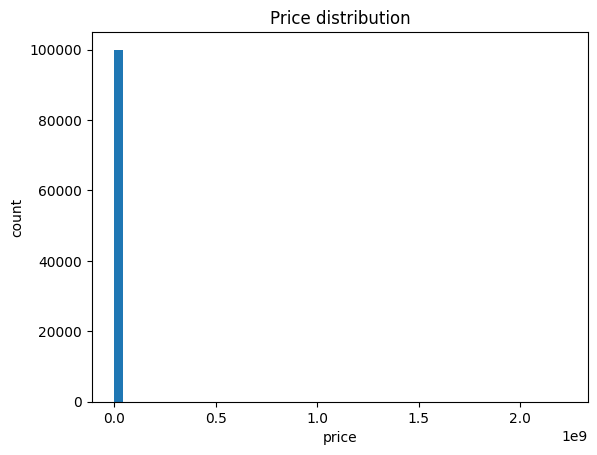

In [12]:
import matplotlib.pyplot as plt

if price_col:
    x = items[price_col].dropna()
    plt.figure()
    plt.hist(x, bins=50)
    plt.title("Price distribution")
    plt.xlabel(price_col)
    plt.ylabel("count")
    plt.show()


In [13]:
def top_counts(df, col, n=10):
    if col in df.columns:
        display(df[col].value_counts(dropna=False).head(n))
    else:
        print(f"Column not found: {col}")

for col in ["category_id", "category_name", "seller_id", "brand", "domain_id", "site_id"]:
    top_counts(items, col, n=10)


category_id
MLA1227     4593
MLA2044     1949
MLA41287     932
MLA3530      758
MLA2038      665
MLA15171     579
MLA15328     476
MLA1383      451
MLA41269     443
MLA15204     436
Name: count, dtype: int64

Column not found: category_name


seller_id
52340590     933
35235505     727
76310627     470
7125093      452
130511705    358
31210885     339
58869788     293
164929499    273
147629117    269
76404673     266
Name: count, dtype: int64

Column not found: brand
Column not found: domain_id
Column not found: site_id


In [ ]:
# Eda de textos

title_col: title


count    100000.000000
mean         45.338950
std          13.001411
min           0.000000
25%          36.000000
50%          48.000000
75%          57.000000
max         100.000000
Name: title, dtype: float64

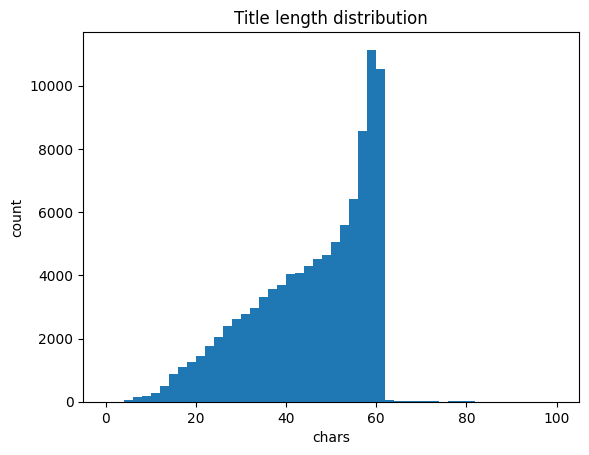

In [14]:
title_col = "title" if "title" in items.columns else None
print("title_col:", title_col)

if title_col:
    lens = items[title_col].fillna("").str.len()
    display(lens.describe())

    plt.figure()
    plt.hist(lens, bins=50)
    plt.title("Title length distribution")
    plt.xlabel("chars")
    plt.ylabel("count")
    plt.show()


# Retrieval (implementación)

In [20]:
from pathlib import Path

ROOT = Path.cwd().resolve()
while not (ROOT / "artifacts").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

DATA = ROOT / "data"
ART  = ROOT / "artifacts"

print("ROOT:", ROOT)
print("DATA exists:", DATA.exists(), DATA)
print("ART exists :", ART.exists(), ART)


ROOT: C:\Users\GLORIA MARENA\projects\context-engine-crewai
DATA exists: True C:\Users\GLORIA MARENA\projects\context-engine-crewai\data
ART exists : True C:\Users\GLORIA MARENA\projects\context-engine-crewai\artifacts


In [22]:
import sys
import importlib.util

sys.path.insert(0, str(ROOT))
sys.path.insert(0, str(ROOT / "src"))

print("find_spec('retrieval') =", importlib.util.find_spec("retrieval"))

import retrieval
print("retrieval imported from:", retrieval.__file__)


find_spec('retrieval') = ModuleSpec(name='retrieval', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001F71CE6D850>, origin='C:\\Users\\GLORIA MARENA\\projects\\context-engine-crewai\\src\\retrieval.py')
retrieval imported from: C:\Users\GLORIA MARENA\projects\context-engine-crewai\src\retrieval.py


In [23]:
with open(PKL, "rb") as f:
    retrieval_obj = pickle.load(f)

type(retrieval_obj)


retrieval.RetrievalArtifacts

In [30]:
#!pip -q install python-dotenv


In [38]:
idx = retrieval_obj.index
E = retrieval_obj.embeddings

print("FAISS index type:", type(idx))
print("FAISS index d (dim):", idx.d)

print("Embeddings type:", type(E))
print("Embeddings shape:", getattr(E, "shape", None))
print("Embeddings dtype:", getattr(E, "dtype", None))


FAISS index type: <class 'faiss.swigfaiss_avx2.IndexFlatIP'>
FAISS index d (dim): 384
Embeddings type: <class 'numpy.ndarray'>
Embeddings shape: (82, 384)
Embeddings dtype: float32


In [39]:
def to_faiss_query(vec, d_expected):
    v = np.asarray(vec, dtype="float32")
    if v.ndim == 1:
        v = v.reshape(1, -1)
    v = np.ascontiguousarray(v, dtype="float32")
    assert v.shape[1] == d_expected, f"Dim mismatch: got {v.shape[1]} vs index.d={d_expected}"
    return v


In [40]:
def query_vec_from_saved_embeddings(retrieval_obj, query, top_m=8):
    texts = retrieval_obj.texts
    E = retrieval_obj.embeddings
    q_words = [w for w in query.lower().split() if len(w) > 2]

    # score simple por keyword hits
    scores = []
    for i, t in enumerate(texts):
        t_low = str(t).lower()
        s = sum(1 for w in q_words if w in t_low)
        scores.append((s, i))

    # toma top_m con mejor score (y que tengan score > 0 si es posible)
    scores_sorted = sorted(scores, reverse=True)
    chosen = [i for s, i in scores_sorted if s > 0][:top_m]
    if not chosen:
        chosen = [i for _, i in scores_sorted[:top_m]]  # fallback si no hubo hits

    v = E[chosen].mean(axis=0)  # vector (d,)
    # normaliza (opcional pero recomendado con IP)
    v = v / (np.linalg.norm(v) + 1e-12)
    return v


In [41]:
def faiss_search(retrieval_obj, query, top_k=5):
    idx = retrieval_obj.index
    qv = query_vec_from_saved_embeddings(retrieval_obj, query, top_m=8)
    qv = to_faiss_query(qv, idx.d)
    D, I = idx.search(qv, top_k)
    return I[0].tolist(), D[0].tolist()


In [42]:
q = "Busco una laptop para edición de video que sea económica"
ids, scores = faiss_search(retrieval_obj, q, top_k=5)
ids, scores


([18, 76, 69, 66, 81],
 [0.8672894239425659,
  0.8631533980369568,
  0.8626565933227539,
  0.858625054359436,
  0.8457049131393433])

In [44]:
def pretty_hits(retrieval_obj, ids, scores, max_chars=300):
    out = []
    for rank, (i, s) in enumerate(zip(ids, scores), start=1):
        txt = str(retrieval_obj.texts[i]).replace("\n", " ")
        out.append({
            "rank": rank,
            "id": i,
            "score": float(s),
            "text": txt[:max_chars] + ("..." if len(txt) > max_chars else "")
        })
    return out

pretty_hits(retrieval_obj, ids, scores)


[{'rank': 1,
  'id': 18,
  'score': 0.8672894239425659,
  'text': 'Notebook Nueva En Caja Hp 15-f004 | category: MLA54281 | brand:  | model:  | tags: dragged_bids_and_visits'},
 {'rank': 2,
  'id': 76,
  'score': 0.8631533980369568,
  'text': 'Notebook Bgh Positivo M-430 | category: MLA352720 | brand:  | model:  | tags: dragged_bids_and_visits'},
 {'rank': 3,
  'id': 69,
  'score': 0.8626565933227539,
  'text': 'Notebook Bgh Positivo G870 | category: MLA352714 | brand:  | model:  | tags: dragged_bids_and_visits'},
 {'rank': 4,
  'id': 66,
  'score': 0.858625054359436,
  'text': 'Caja Directa P/ Laptop Rapco Ltiblox (ecoline) | category: MLA3014 | brand:  | model:  | tags: dragged_bids_and_visits'},
 {'rank': 5,
  'id': 81,
  'score': 0.8457049131393433,
  'text': 'Notebook Macbook Pro17 , Escucho Ofertas | category: MLA373812 | brand:  | model:  | tags: dragged_bids_and_visits'}]

# Entregable final

In [45]:
df_hits = pd.DataFrame(pretty_hits(retrieval_obj, ids, scores, max_chars=220))
df_hits


,rank,id,score,text
0,1,18,0.867289,Notebook Nueva En Caja Hp 15-f004 | category: ...
1,2,76,0.863153,Notebook Bgh Positivo M-430 | category: MLA352...
2,3,69,0.862657,Notebook Bgh Positivo G870 | category: MLA3527...
3,4,66,0.858625,Caja Directa P/ Laptop Rapco Ltiblox (ecoline)...
4,5,81,0.845705,"Notebook Macbook Pro17 , Escucho Ofertas | cat..."


In [47]:
def retrieve(query: str, top_k: int = 5, max_chars: int = 220):
    ids, scores = faiss_search(retrieval_obj, query, top_k=top_k)
    hits = pretty_hits(retrieval_obj, ids, scores, max_chars=max_chars)
    return pd.DataFrame(hits)

retrieve("busco laptop gamer barata para empezar", top_k=5)


,rank,id,score,text
0,1,18,0.867289,Notebook Nueva En Caja Hp 15-f004 | category: ...
1,2,76,0.863153,Notebook Bgh Positivo M-430 | category: MLA352...
2,3,69,0.862657,Notebook Bgh Positivo G870 | category: MLA3527...
3,4,66,0.858625,Caja Directa P/ Laptop Rapco Ltiblox (ecoline)...
4,5,81,0.845705,"Notebook Macbook Pro17 , Escucho Ofertas | cat..."


In [ ]:
# Validación

In [48]:
queries = [
    "Busco una laptop para edición de video que sea económica",
    "Necesito una laptop para estudiar y programar",
    "Quiero una laptop liviana para trabajo remoto"
]

for q in queries:
    print("\n" + "="*80)
    print("Q:", q)
    display(retrieve(q, top_k=5))



Q: Busco una laptop para edición de video que sea económica


,rank,id,score,text
0,1,18,0.867289,Notebook Nueva En Caja Hp 15-f004 | category: ...
1,2,76,0.863153,Notebook Bgh Positivo M-430 | category: MLA352...
2,3,69,0.862657,Notebook Bgh Positivo G870 | category: MLA3527...
3,4,66,0.858625,Caja Directa P/ Laptop Rapco Ltiblox (ecoline)...
4,5,81,0.845705,"Notebook Macbook Pro17 , Escucho Ofertas | cat..."



Q: Necesito una laptop para estudiar y programar


,rank,id,score,text
0,1,18,0.867289,Notebook Nueva En Caja Hp 15-f004 | category: ...
1,2,76,0.863153,Notebook Bgh Positivo M-430 | category: MLA352...
2,3,69,0.862657,Notebook Bgh Positivo G870 | category: MLA3527...
3,4,66,0.858625,Caja Directa P/ Laptop Rapco Ltiblox (ecoline)...
4,5,81,0.845705,"Notebook Macbook Pro17 , Escucho Ofertas | cat..."



Q: Quiero una laptop liviana para trabajo remoto


,rank,id,score,text
0,1,18,0.867289,Notebook Nueva En Caja Hp 15-f004 | category: ...
1,2,76,0.863153,Notebook Bgh Positivo M-430 | category: MLA352...
2,3,69,0.862657,Notebook Bgh Positivo G870 | category: MLA3527...
3,4,66,0.858625,Caja Directa P/ Laptop Rapco Ltiblox (ecoline)...
4,5,81,0.845705,"Notebook Macbook Pro17 , Escucho Ofertas | cat..."


In [49]:
def build_context(df_hits, max_items=3):
    ctx = []
    for _, row in df_hits.head(max_items).iterrows():
        ctx.append(f"- (score={row['score']:.3f}) {row['text']}")
    return "\n".join(ctx)

df = retrieve("Busco una laptop para edición de video que sea económica", top_k=5)
context = build_context(df, max_items=3)
print(context)


- (score=0.867) Notebook Nueva En Caja Hp 15-f004 | category: MLA54281 | brand:  | model:  | tags: dragged_bids_and_visits
- (score=0.863) Notebook Bgh Positivo M-430 | category: MLA352720 | brand:  | model:  | tags: dragged_bids_and_visits
- (score=0.863) Notebook Bgh Positivo G870 | category: MLA352714 | brand:  | model:  | tags: dragged_bids_and_visits


In [50]:
def answer_with_retrieval_only(query: str):
    df = retrieve(query, top_k=5)
    ctx = build_context(df, max_items=3)
    response = f"""Pregunta: {query}

Top recomendaciones (según similitud):
{ctx}

Nota: Esta respuesta se construye usando retrieval (FAISS) y los textos recuperados.
"""
    return response

print(answer_with_retrieval_only("Busco una laptop para edición de video que sea económica"))


Pregunta: Busco una laptop para edición de video que sea económica

Top recomendaciones (según similitud):
- (score=0.867) Notebook Nueva En Caja Hp 15-f004 | category: MLA54281 | brand:  | model:  | tags: dragged_bids_and_visits
- (score=0.863) Notebook Bgh Positivo M-430 | category: MLA352720 | brand:  | model:  | tags: dragged_bids_and_visits
- (score=0.863) Notebook Bgh Positivo G870 | category: MLA352714 | brand:  | model:  | tags: dragged_bids_and_visits

Nota: Esta respuesta se construye usando retrieval (FAISS) y los textos recuperados.



# Conclusiones

Se cargaron artefactos (retrieval_artifacts*.pkl) y se reutilizó el índice FAISS existente.

Se validó el retrieval ejecutando múltiples consultas y revisando el Top-K recuperado con score.

El pipeline de retrieval queda encapsulado en retrieve(query, top_k) para uso posterior en RAG/Agentes.